In [1]:
%load_ext autoreload
%autoreload 2

In [127]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import utils
import pandas as pd
import seaborn as sns
from functools import partial
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy import stats

In [40]:
df = pd.read_csv("data/UFClefties.csv", sep=";")
df.head()

,fight,episode,fight.in.episode,fighter1.win,fighter1,fighter2,fighter1.lefty,fighter2.lefty
0,1181,118,1,0,146,175,1,1
1,1182,118,2,0,133,91,1,0
2,1183,118,3,1,56,147,1,0
3,1184,118,4,1,192,104,0,0
4,1185,118,5,1,79,15,0,0


244

In [67]:
fighter_ids2idx = {id:idx for idx, id in enumerate(np.unique(pd.concat([df.fighter1, df.fighter2])))}
fighter_idx2id = {idx:id for id, idx in fighter_ids2idx.items()}
df['fighter1_idx'] = df.fighter1.map(fighter_ids2idx)
df['fighter2_idx'] = df.fighter2.map(fighter_ids2idx)

In [91]:
fighters = np.unique(pd.concat([df.fighter1, df.fighter2]).values)
coords = {
    "fighter_dim": fighter_ids2idx.values(),
}

with pm.Model(coords=coords) as model:
    fighter1_idx = pm.MutableData("fighter1_idx", df.fighter1_idx)
    fighter2_idx = pm.MutableData("fighter2_idx", df.fighter2_idx)
    L1 = pm.MutableData("L1", df["fighter1.lefty"])
    L2 = pm.MutableData("L2", df["fighter2.lefty"])

    fighter_bias = pm.Normal("fighter_bias", mu=0, sigma=1, dims="fighter_dim")
    lefty_bias = pm.Normal("lefty_bias", mu=0, sigma=1)

    fighter1 = fighter_bias[fighter1_idx] + lefty_bias * L1
    fighter2 = fighter_bias[fighter2_idx] + lefty_bias * L2

    f1_advantage = fighter1 - fighter2
    f1_advantage = pm.Deterministic("f1_advantage", f1_advantage)
    p = pm.math.sigmoid(f1_advantage)
    p = pm.Deterministic("p", p)

    winner = pm.Bernoulli("winner", p, observed=df["fighter1.win"])
    trace = pm.sample(2000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [fighter_bias, lefty_bias]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.


In [152]:
with pm.Model() as model2:
    beta = pm.Normal("beta", mu=0, sigma=1)
    p = pm.math.sigmoid(beta * (df["fighter1.lefty"] - df["fighter2.lefty"]))
    p = pm.Deterministic("p", p)
    winner = pm.Bernoulli("winner", p, observed=df["fighter1.win"])
    trace2 = pm.sample(2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.


<AxesSubplot:title={'center':'beta'}>

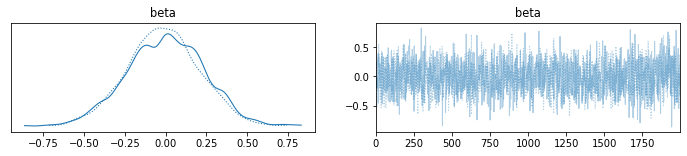

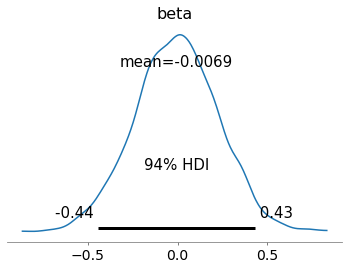

In [153]:
az.summary(trace2, var_names=["beta"])
az.plot_trace(trace2, var_names=["beta"])
az.plot_posterior(trace2, var_names=["beta"])

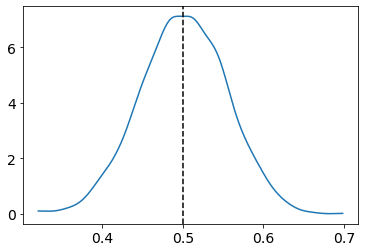

In [126]:
az.plot_dist(
    np.exp(trace2.posterior["beta"]) / (1 + np.exp(trace2.posterior["beta"])),
)
plt.axvline(0.5, color="black", linestyle="--")